## This notebook generates the components of Figure 3

in "Entrained debris records regrowth of the Greenland Ice Sheet after the last interglacial" 

---
That figure contains the following components

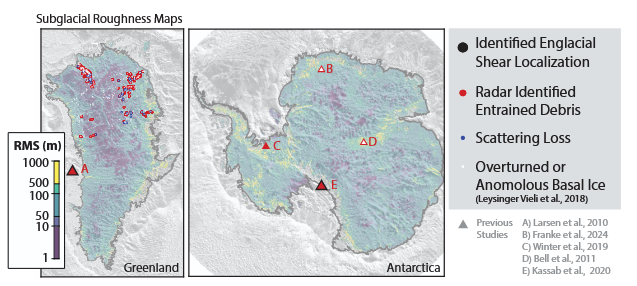

In [13]:
#############################################
### Necessary input statements

######## System untilities
import os
import shutil
import sys
import glob

######## Numerical and plotting tools
import tqdm
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

######## Hillshade Utility
import earthpy.spatial as es

######## Any necessary path additions can go here:
sys.path.append('/mnt/data01/Code/opr_python/')

######## OPR library tools
import opr_python as ndh

generate_pdfs_flag = 0
data_root = '/mnt/data02/Dataverse_TestData/EntrainedDebris/'

In [2]:
#################################################
### To generate the roughness maps requires bedmachine Greenland
### and Bedmap 3, sourced from there repositories

bm_greenland_path = '/mnt/data01/Data/Greenland_BedElevation/BedMachineGreenland-v5-2022-09-01.nc'
bm_antarctica_path = '/mnt/data01/Data/Antarctic_BedElevation/bedmap3.nc'

dems = []
dems.append(xr.open_dataset(bm_greenland_path))
dems.append(xr.open_dataset(bm_antarctica_path))

bed_key = ['bed','bed_topography']
mask_key = ['mask','mask']
mask_target = [2,1]

In [4]:
##################################
### Load LeysingerVieli Picks

### As with Bedmachine and Bedmap3, the folds picked by LeysingerVieli
### must be sourced from here: https://zenodo.org/records/1435749
LV_data_file_path = '../../../../Petermann_SwathWork/Published_Datasets/LeysingerVieli_BodyPicks/complete_plumbigpeakpoints_clear_sieved.mat'

peak_coords = ndh.loadmat(LV_data_file_path)
peak_keys = list(peak_coords.keys())
key_pairs = [[7,9],[8,10],[11,12],[13,15],[14,16]]

total_x = []
total_y = []
for i in key_pairs:
    key1 = peak_keys[i[0]]
    key2 = peak_keys[i[1]]
    total_x.append(peak_coords[key1])
    total_y.append(peak_coords[key2])

total_x = ndh.flatten_list(total_x)
total_y = ndh.flatten_list(total_y)

In [27]:
#####################################
### Load Attenuation Picks

bp = ndh.loadmat(data_root+'Identified_PowerLossFeatures.mat')
pl_x = bp['x']
pl_y = bp['y']

#####################################
### Load XTrack Scattering Picks
xtrack = ndh.loadmat(data_root+'DebrisTrains_identified_in_MusicVolumes.mat')

In [28]:
#####################################
### This cell calculates the RMS roughness and saves the results, so you only have to do it once.

if os.path.isfile('../../../../Entrainment_Maps/Roughness_10km.mat'):
    roughness_dict = ndh.loadmat('../../../../Entrainment_Maps/Roughness_10km.mat')
    
elif os.path.isfile('Roughness_10km.mat'):
    roughness_dict = ndh.loadmat('Roughness_10km.mat')
    
else: 
    roughness_scale = 10000
    ds_fac = 1000
    ras = []
    rmss = []
    nxs = []
    nys = []
    hillshades = []
    
    for dem_ind,dem in enumerate(dems):
        dx = dem['x'].values[1] - dem['x'].values[0]
        ds = int(ds_fac/dx)
    
        nx = dem['x'].values[::ds]
        ny = dem['y'].values[::ds]
        
        index_range = int(roughness_scale/dx/2)
        ra = np.zeros([len(ny),len(nx)])
        rms = np.zeros([len(ny),len(nx)])
    
        for row in tqdm.tqdm(np.arange(len(ny))):
            for col in np.arange(len(nx)):
                if dem[mask_key[dem_ind]][row*ds,col*ds] == mask_target[dem_ind]:
                    lix = np.max([0,col*ds-index_range])
                    hix = np.min([len(dem['x'].values),col*ds+index_range])
                    liy = np.max([0,row*ds-index_range])
                    hiy = np.min([len(dem['y'].values),row*ds+index_range])
        
                    dem_sub = dem[bed_key[dem_ind]][liy:hiy+1,lix:hix+1].values
                    sub_size = np.prod(dem_sub.shape)
                    mv = np.mean(dem_sub)
                    ra_val = np.sum(np.abs(dem_sub-mv))/sub_size
                    rms_val = np.sqrt(np.sum(np.abs(dem_sub-mv)**2/sub_size))
        
                    ra[row,col] = ra_val
                    rms[row,col] = rms_val
                else:
                    ra[row,col] = np.nan
                    rms[row,col] = np.nan
        ras.append(ra)
        rmss.append(rms)
        nxs.append(nx)
        nys.append(ny)
    
        hs =es.hillshade(dem[bed_key[dem_ind]])
        hillshades.append(hs)
                
    roughness_dict = {'rms':rmss,'ra':ras,'nx':nxs,'ny':nys, 'hillshades':hillshades}
    ndh.savemat(roughness_dict,'Roughness_10km.mat')

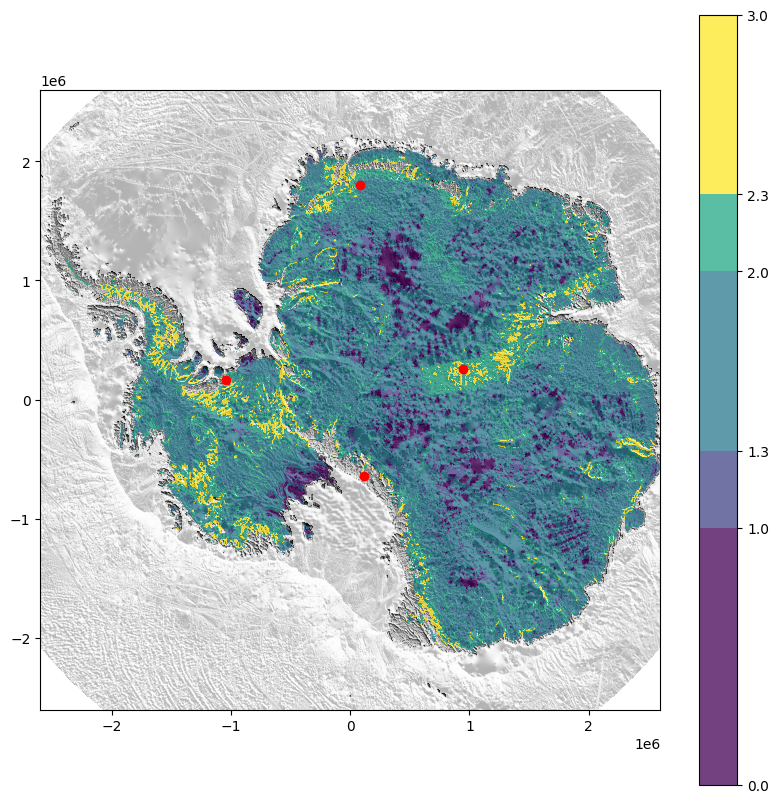

In [30]:
###################################################
### Antarctic Map
###################################################
em = pd.read_excel(data_root+'Entrainment_in_Literature.xlsx')
ki = em['Continent'] == 'Ant'
xy = ndh.polarstereo_fwd(em['Lat'],em['Lon'])


divisions = [0, 1,1.3, 2,2.3, 3]
cmap = plt.get_cmap('viridis', len(divisions))
norm = BoundaryNorm(divisions, cmap.N)

ti = 1

dem = dems[ti]
new_mask = np.array(dem[mask_key[ti]].values != mask_target[ti]).astype(float)
new_mask[new_mask == 0] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(roughness_dict['hillshades'][ti],
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower')

plt.imshow(new_mask,
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower',alpha=0.7)

cdata = plt.imshow(np.log10(roughness_dict['ra'][ti]),
                   extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
                    cmap=cmap,norm=norm,alpha=0.75,origin='lower')

plt.plot(xy['x'],xy['y'],'o',c='red')
plt.colorbar(cdata,ticks=divisions,spacing='proportional')
val = 2.6e6;
plt.xlim([-val,val])
plt.ylim([-val,val])

if generate_pdfs_flag == 1:
    plt.savefig('Antarctica.pdf')

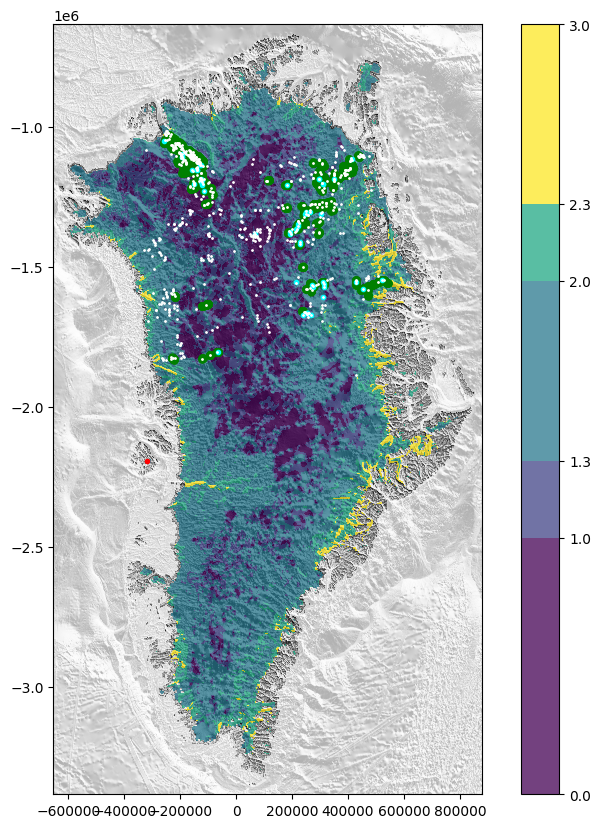

In [32]:
###################################################
### Greenland Map
###################################################

em = pd.read_excel(data_root+'/Entrainment_in_Literature.xlsx')
ki = em['Continent'] == 'Gre'
xy = ndh.polarstereo_fwd(em['Lat'][ki],em['Lon'][ki])

divisions = [0, 1,1.3, 2,2.3, 3]
cmap = plt.get_cmap('viridis', len(divisions))
norm = BoundaryNorm(divisions, cmap.N)

ti = 0

dem = dems[ti]
new_mask = np.array(dem[mask_key[ti]].values != mask_target[ti]).astype(float)
new_mask[new_mask == 0] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(roughness_dict['hillshades'][ti],
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower')

plt.imshow(new_mask,
           extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
           cmap='Grays',origin='lower',alpha=0.7)

cdata = plt.imshow(np.log10(roughness_dict['ra'][ti]),
                   extent=[roughness_dict['nx'][ti][0],roughness_dict['nx'][ti][-1],roughness_dict['ny'][ti][0],roughness_dict['ny'][ti][-1]],
                    cmap=cmap,norm=norm,alpha=0.75,origin='lower')

plt.plot(xtrack['x'],xtrack['y'],'.',c='green',ms=10)
plt.plot(pl_x,pl_y,'.',c='cyan',ms=6)
plt.plot(total_x,total_y,'.',c='white',ms=2)
plt.plot(xy['x'],xy['y'],'.',c='red')

plt.colorbar(cdata,ticks=divisions,spacing='proportional')
plt.gca().invert_yaxis()

if generate_pdfs_flag == 1:
    plt.savefig('Greenland_v2.pdf')